The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1


# Adagrad
:label:`sec_adagrad`

Vamos começar considerando os problemas de aprendizado com recursos que ocorrem com pouca frequência.

## Recursos esparsos e taxas de aprendizado

Imagine que estamos treinando um modelo de linguagem. Para obter uma boa precisão, normalmente queremos diminuir a taxa de aprendizado à medida que continuamos treinando, normalmente a uma taxa de $\mathcal{O}(t^{-\frac{1}{2}})$ ou mais lenta. Agora, considere um treinamento de modelo em recursos esparsos, ou seja, recursos que ocorrem raramente. Isso é comum para a linguagem natural, por exemplo, é muito menos provável que vejamos a palavra *précondicionamento* do que *aprendizagem*. No entanto, também é comum em outras áreas, como publicidade computacional e filtragem colaborativa personalizada. Afinal, existem muitas coisas que interessam apenas a um pequeno número de pessoas.

Os parâmetros associados a recursos pouco frequentes recebem apenas atualizações significativas sempre que esses recursos ocorrem. Dada uma taxa de aprendizado decrescente, podemos acabar em uma situação em que os parâmetros para características comuns convergem rapidamente para seus valores ideais, enquanto para características raras ainda não podemos observá-los com frequência suficiente antes que seus valores ideais possam ser determinados. Em outras palavras, a taxa de aprendizado diminui muito lentamente para recursos freqüentes ou muito rapidamente para recursos pouco frequentes.

Um possível hack para corrigir esse problema seria contar o número de vezes que vemos um determinado recurso e usar isso como um relógio para ajustar as taxas de aprendizagem. Ou seja, em vez de escolher uma taxa de aprendizagem da forma $\eta = \frac{\eta_0}{\sqrt{t + c}}$ poderiamos usar $\eta_i = \frac{\eta_0}{\sqrt{s(i, t) + c}}$ conta o número de valores diferentes de zero para o recurso $i$ que observamos até o momento $t$. Na verdade, isso é muito fácil de implementar sem sobrecarga significativa. No entanto, ele falha sempre que não temos esparsidade, mas apenas dados em que os gradientes são frequentemente muito pequenos e raramente grandes. Afinal, não está claro onde se traçaria a linha entre algo que se qualifica como uma característica observada ou não.

Adagrad by :cite:`Duchi.Hazan.Singer.2011` aborda isso substituindo o contador bastante bruto $s(i, t)$ por um agregado de quadrados de gradientes previamente observados. Em particular, ele usa $s(i, t+1) = s(i, t) + \left(\partial_i f(\mathbf{x})\right)^2$ como um meio de ajustar a taxa de aprendizagem. Isso tem dois benefícios: primeiro, não precisamos mais decidir apenas quando um gradiente é grande o suficiente. Em segundo lugar, ele é dimensionado automaticamente com a magnitude dos gradientes. As coordenadas que normalmente correspondem a grandes gradientes são reduzidas significativamente, enquanto outras com pequenos gradientes recebem um tratamento muito mais suave. Na prática, isso leva a um procedimento de otimização muito eficaz para publicidade computacional e problemas relacionados. Mas isso oculta alguns dos benefícios adicionais inerentes ao Adagrad que são mais bem compreendidos no contexto do pré-condicionamento.


## Precondicionamento

Problemas de otimização convexa são bons para analisar as características dos algoritmos. Afinal, para a maioria dos problemas não-convexos, é difícil derivar garantias teóricas significativas, mas a *intuição* e o *insight* geralmente são transmitidos. Vejamos o problema de minimizar $f(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{c}^\top \mathbf{x} + b$.

Como vimos em :numref:`sec_momentum`, é possível reescrever este problema em termos de sua composição automática $\mathbf{Q} = \mathbf{U}^\top \boldsymbol{\Lambda} \mathbf{U}$ para chegar a um problema muito simplificado onde cada coordenada pode ser resolvida individualmente:

$$f(\mathbf{x}) = \bar{f}(\bar{\mathbf{x}}) = \frac{1}{2} \bar{\mathbf{x}}^\top \boldsymbol{\Lambda} \bar{\mathbf{x}} + \bar{\mathbf{c}}^\top \bar{\mathbf{x}} + b.$$

Aqui usamos $\mathbf{x} = \mathbf{U} \mathbf{x}$ e consequentemente $\mathbf{c} = \mathbf{U} \mathbf{c}$. O problema modificado tem como minimizador $\bar{\mathbf{x}} = -\boldsymbol{\Lambda}^{-1} \bar{\mathbf{c}}$ e valor mínimo $-\frac{1}{2} \bar{\mathbf{c}}^\top \boldsymbol{\Lambda}^{-1} \bar{\mathbf{c}} + b$. Isso é muito mais fácil de calcular, pois $\boldsymbol{\Lambda}$ é uma matriz diagonal contendo os autovalores de $\mathbf{Q}$.

Se perturbarmos $\mathbf{c}$ ligeiramente, esperaríamos encontrar apenas pequenas mudanças no minimizador de $ f $. Infelizmente, esse não é o caso. Embora pequenas mudanças em $\mathbf{c}$ levem a mudanças igualmente pequenas em $\bar{\mathbf{c}}$, este não é o caso para o minimizador de $f$ (e de $\bar{f}$ respectivamente). Sempre que os autovalores $\boldsymbol{\Lambda}_i$ forem grandes, veremos apenas pequenas mudanças em $\bar{x}_i$ e no mínimo de $\bar{f}$. Por outro lado, para pequenas $\boldsymbol{\Lambda}_i$, as mudanças em $\bar{x}_i$ podem ser dramáticas. A razão entre o maior e o menor autovalor é chamada de número de condição de um problema de otimização.

$$\kappa = \frac{\boldsymbol{\Lambda}_1}{\boldsymbol{\Lambda}_d}.$$

Se o número de condição $\kappa$ for grande, será difícil resolver o problema de otimização com precisão. Precisamos garantir que somos cuidadosos ao acertar uma ampla faixa dinâmica de valores. Nossa análise leva a uma questão óbvia, embora um tanto ingênua: não poderíamos simplesmente "consertar" o problema distorcendo o espaço de forma que todos os autovalores sejam $1$. Em teoria, isso é muito fácil: precisamos apenas dos autovalores e autovetores de $\mathbf{Q}$ para redimensionar o problema de $\mathbf{x}$ para um em $\mathbf{z} := \boldsymbol{\Lambda}^{\frac{1}{2}} \mathbf{U} \mathbf{x}$. No novo sistema de coordenadas $\mathbf{x}^\top \mathbf{Q} \mathbf{x}$ poderia ser simplificado para $\|\mathbf{z}\|^2$. Infelizmente, esta é uma sugestão pouco prática. O cálculo de autovalores e autovetores é em geral muito mais caro do que resolver o problema real.

Embora o cálculo exato dos autovalores possa ser caro, adivinhá-los e computá-los de forma aproximada já pode ser muito melhor do que não fazer nada. Em particular, poderíamos usar as entradas diagonais de $\mathbf{Q}$ e redimensioná-las de acordo. Isso é *muito* mais barato do que calcular valores próprios.

$$\tilde{\mathbf{Q}} = \mathrm{diag}^{-\frac{1}{2}}(\mathbf{Q}) \mathbf{Q} \mathrm{diag}^{-\frac{1}{2}}(\mathbf{Q}).$$

Neste caso, temos $\tilde{\mathbf{Q}}_{ij} = \mathbf{Q}_{ij} / \sqrt{\mathbf{Q}_{ii} \mathbf{Q}_{jj}}$ e especificamente $\tilde{\mathbf{Q}}_{ii} = 1$ para todo $i$. Na maioria dos casos, isso simplifica consideravelmente o número da condição. Por exemplo, nos casos que discutimos anteriormente, isso eliminaria totalmente o problema em questão, uma vez que o problema está alinhado ao eixo.

Infelizmente, enfrentamos ainda outro problema: no aprendizado profundo, normalmente nem mesmo temos acesso à segunda derivada da função objetivo: para $\mathbf{x} \in \mathbb{R}^d$ a segunda derivada, mesmo em um minibatch pode exigir $\mathcal{O}(d^2)$ espaço e trabalho para computar, tornando-o praticamente inviável. A ideia engenhosa do Adagrad é usar um proxy para aquela diagonal indescritível do Hessian que é relativamente barato para calcular e eficaz--- a magnitude do gradiente em si.

Para ver por que isso funciona, vamos dar uma olhada em $\bar{f}(\bar{\mathbf{x}})$. Nós temos isso

$$\partial_{\bar{\mathbf{x}}} \bar{f}(\bar{\mathbf{x}}) = \boldsymbol{\Lambda} \bar{\mathbf{x}} + \bar{\mathbf{c}} = \boldsymbol{\Lambda} \left(\bar{\mathbf{x}} - \bar{\mathbf{x}}_0\right),$$

onde $\bar{\mathbf{x}}_0$ é o minimizador de $\bar{f}$. Portanto, a magnitude do gradiente depende tanto de $\boldsymbol{\Lambda}$ quanto da distância da otimalidade. Se $\bar{\mathbf{x}} - \bar{\mathbf{x}}_0$ não mudou, isso seria tudo o que é necessário. Afinal, neste caso, a magnitude do gradiente $\partial_{\bar{\mathbf{x}}} \bar{f}(\bar{\mathbf{x}})$ é suficiente. Como o AdaGrad é um algoritmo descendente de gradiente estocástico, veremos gradientes com variância diferente de zero mesmo em otimização. Como resultado, podemos usar com segurança a variância dos gradientes como um proxy barato para a escala de Hessian. Uma análise completa está além do escopo desta seção (seriam várias páginas). Recomendamos ao leitor :cite:`Duchi.Hazan.Singer.2011` para detalhes.

## O Algoritmo

Vamos formalizar a discussão de cima. Usamos a variável $\mathbf{s}_t$ para acumular a variância do gradiente anterior como segue.

$$\begin{aligned}
    \mathbf{g}_t & = \partial_{\mathbf{w}} l(y_t, f(\mathbf{x}_t, \mathbf{w})), \\
    \mathbf{s}_t & = \mathbf{s}_{t-1} + \mathbf{g}_t^2, \\
    \mathbf{w}_t & = \mathbf{w}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \cdot \mathbf{g}_t.
\end{aligned}$$

Aqui, as operações são aplicadas de acordo com as coordenadas. Ou seja, $\mathbf{v}^2$ tem entradas $v_i^2$. Da mesma forma, $\frac{1}{\sqrt{v}}$ tem entradas $\frac{1}{\sqrt{v_i}}$ e $\mathbf{u} \cdot \mathbf{v}$ tem entradas $u_i v_i$. Como antes, $\eta$ é a taxa de aprendizagem e $\epsilon$ é uma constante aditiva que garante que não dividamos por $0$. Por último, inicializamos $\mathbf{s}_0 = \mathbf{0}$.

Assim como no caso do momentum, precisamos manter o controle de uma variável auxiliar, neste caso para permitir uma taxa de aprendizagem individual por coordenada. Isso não aumenta o custo do Adagrad significativamente em relação ao SGD, simplesmente porque o custo principal normalmente é calcular $l(y_t, f(\mathbf{x}_t, \mathbf{w}))$ e sua derivada.

Observe que o acúmulo de gradientes quadrados em $\mathbf{s}_t$ significa que $\mathbf{s}_t$ cresce essencialmente a uma taxa linear (um pouco mais lento do que linearmente na prática, uma vez que os gradientes inicialmente diminuem). Isso leva a uma taxa de aprendizado $\mathcal{O}(t^{-\frac{1}{2}})$, embora ajustada por coordenada. Para problemas convexos, isso é perfeitamente adequado. No aprendizado profundo, porém, podemos querer diminuir a taxa de aprendizado um pouco mais lentamente. Isso levou a uma série de variantes do Adagrad que discutiremos nos capítulos subsequentes. Por enquanto, vamos ver como ele se comporta em um problema convexo quadrático. Usamos o mesmo problema de antes:

$$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2.$$

Vamos implementar o Adagrad usando a mesma taxa de aprendizado anterior, ou seja, $\eta = 0.4$. Como podemos ver, a trajetória iterativa da variável independente é mais suave. No entanto, devido ao efeito cumulativo de $\boldsymbol{s}_t$, a taxa de aprendizado diminui continuamente, de modo que a variável independente não se move tanto durante os estágios posteriores da iteração.


In [1]:
%matplotlib inline
import math
import torch
from d2l import torch as d2l

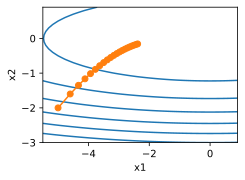

In [2]:
def adagrad_2d(x1, x2, s1, s2):
    eps = 1e-6
    g1, g2 = 0.2 * x1, 4 * x2
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

Conforme aumentamos a taxa de aprendizado para $2$, vemos um comportamento muito melhor. Isso já indica que a diminuição na taxa de aprendizagem pode ser bastante agressiva, mesmo no caso sem ruído e precisamos garantir que os parâmetros convirjam de forma adequada.


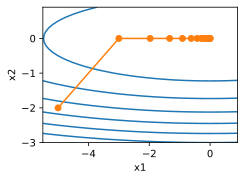

In [3]:
eta = 2
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

## Implementação do zero

Assim como o método momentum, o Adagrad precisa manter uma variável de estado da mesma forma que os parâmetros.


In [4]:
def init_adagrad_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] += torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

Comparado com o experimento em :numref:`sec_minibatch_sgd`, usamos um
maior taxa de aprendizagem para treinar o modelo.


loss: 0.244, 0.012 sec/epoch


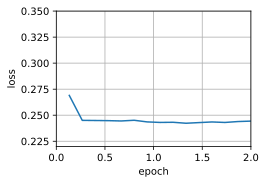

In [5]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adagrad, init_adagrad_states(feature_dim),
               {'lr': 0.1}, data_iter, feature_dim);

## Implementação concisa

Usando a instância `Trainer` do algoritmo `adagrad`, podemos invocar o algoritmo Adagrad no Gluon.


loss: 0.243, 0.013 sec/epoch


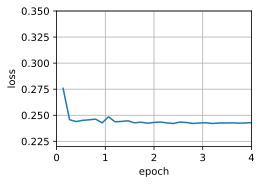

In [6]:
trainer = torch.optim.Adagrad
d2l.train_concise_ch11(trainer, {'lr': 0.1}, data_iter)

## Sumário

* O Adagrad diminui a taxa de aprendizagem dinamicamente por coordenada.
* Ele usa a magnitude do gradiente como um meio de ajustar a rapidez com que o progresso é alcançado - as coordenadas com gradientes grandes são compensadas com uma taxa de aprendizado menor.
* Calcular a segunda derivada exata é tipicamente inviável em problemas de aprendizado profundo devido a limitações de memória e computacionais. O gradiente pode ser um proxy útil.
* Se o problema de otimização tiver uma estrutura bastante irregular, o Adagrad pode ajudar a mitigar a distorção.
* O Adagrad é particularmente eficaz para recursos esparsos em que a taxa de aprendizado precisa diminuir mais lentamente para termos que ocorrem com pouca frequência.
* Em problemas de aprendizado profundo, o Adagrad às vezes pode ser muito agressivo na redução das taxas de aprendizado. Discutiremos estratégias para mitigar isso no contexto de :numref:`sec_adam`.

## Exercícios

1. Prove que para uma matriz ortogonal $\mathbf{U}$ e um vetor $\mathbf{c}$ o seguinte é válido: $\|\mathbf{c} - \mathbf{\delta}\|_2 = \|\mathbf{U} \mathbf{c} - \mathbf{U} \mathbf{\delta}\|_2$. Por que isso significa que a magnitude das perturbações não muda após uma mudança ortogonal das variáveis?
1. Experimente o Adagrad para $f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2$ e também para a função objetivo foi girada em 45 graus, ou seja, $f(\mathbf{x}) = 0.1 (x_1 + x_2)^2 + 2 (x_1 - x_2)^2$. Ele se comporta de maneira diferente?
1. Prove [teorema do círculo de Gerschgorin](https://en.wikipedia.org/wiki/Gershgorin_circle_theorem) que afirma que os valores próprios $\lambda_i$ de uma matriz $\mathbf{M}$ satisfazer $|\lambda_i - \mathbf{M}_{jj}| \leq \sum_{k \neq j} |\mathbf{M}_{jk}|$ para pelo menos uma escolha de $j$.
1. O que o teorema de Gerschgorin nos diz sobre os autovalores da matriz pré-condicionada diagonalmente $\mathrm{diag}^{-\frac{1}{2}}(\mathbf{M}) \mathbf{M} \mathrm{diag}^{-\frac{1}{2}}(\mathbf{M})$?
1. Experimente o Adagrad para uma rede profunda adequada, como :numref:`sec_lenet` quando aplicado ao Fashion MNIST.
1. Como você precisaria modificar o Adagrad para atingir uma queda menos agressiva na taxa de aprendizado?


[Discussão](https://discuss.d2l.ai/t/1072)


<!--stackedit_data:
eyJoaXN0b3J5IjpbMjE0MDgwODc1MCwxNTM2ODY3Mzc1LDE2NT
IxNDMwNjNdfQ==
-->
